In [ ]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import os
import sunpy.map
import aiapy
from aiapy.calibrate.prep import register as aiaprep 
from sunpy.net import Fido, attrs as a
from astropy import units as u
import datetime
import glob
plt.rcParams.update({'figure.autolayout': True})
from matplotlib.ticker import MaxNLocator
from aiapy.calibrate import update_pointing
from sunpy.physics.differential_rotation import solar_rotate_coordinate
import numpy as np
import warnings
warnings.filterwarnings("ignore")

0,2.902055
2.902059
2.90206
2.902062
2.902057
2.902057
2.902059
2.902058
2.902056
2.902057
10,2.902058
2.902057
2.902058
2.902058
2.902054
2.902049
2.902055
2.90206
2.902059
2.902057
20,2.902057
2.902058
2.902055
2.902059
2.902056
2.902058
2.902057
2.902058
2.902058
2.902058
30,2.902056
2.902058
2.902057
2.90206
2.902054
2.90205
2.902057
2.902059
2.902057
2.902061
40,2.902057
2.902058
2.902058
2.902058
2.902058
2.902055
2.902058
2.90206
2.902059
2.902059
50,2.902055
2.90206
2.902056
2.90206
2.902056
2.902057
2.902059
2.902051
2.902056
2.902058
60,2.90206
2.902061
2.90206
2.902062
2.90206
2.902061
2.902059
2.902061
2.902059
2.902059
70,2.902057
2.902057
2.902056
2.902057
2.902057
2.902056
2.902056
2.902057
2.902058
2.902062
80,2.902061
2.902062
2.90206
2.90206
2.902061
2.902062
2.902061
2.902063
2.90206
2.902061
90,2.902057
2.902056
2.902061
2.902063
2.902062
2.902066
2.902061
2.902062
2.902062
2.90206
100,2.902061
2.902061
2.902062
2.902063
2.902063
2.902064
2.902062
2.902061
2.902064


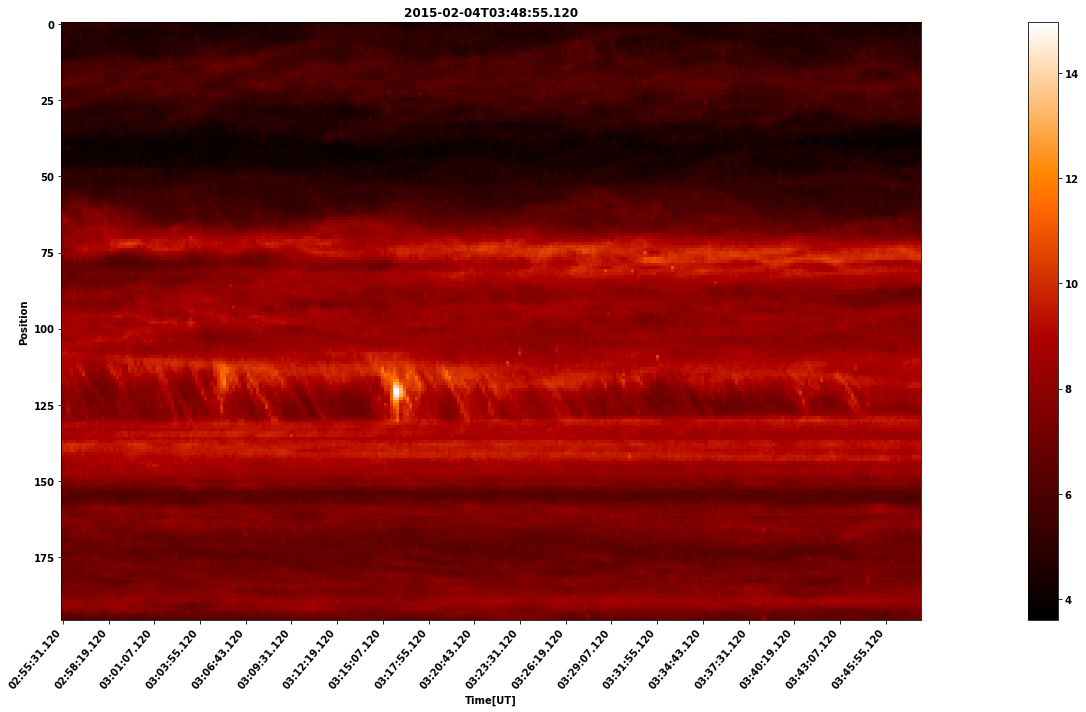

In [9]:
plt.rcParams.update({'figure.autolayout': True})
from matplotlib.ticker import MaxNLocator
df = pd.read_excel('IRIS_AIA.xlsx' , sheet_name='Tabelle3')

folder = '/Users/delbe/OneDrive - FHNW/aia_304/'
    
for label, row in df.iterrows():
    p1_x1 = row[1]
    p1_y1 = row[2]
    p2_x2 = row[3]
    p2_y2 = row[4]

    # time_axis = row[5].split("T")

    gradient = (p2_y2-p1_y1)/(p2_x2-p1_x1)
    origin = p1_y1 - gradient * p1_x1

    y = np.arange(min(p1_y1, p2_y2),max(p1_y1, p2_y2)+1)
    x = (y - origin) / gradient

    coords = (np.column_stack((x.round().astype(int),y.astype(int))))
    
    files = glob.glob(folder + row[0] + "/*")

    aia0_map = sunpy.map.Map(files[0])
    aiaN_map = sunpy.map.Map(files[-1])

    aia0_date = aia0_map.date
    aiaN_date = aiaN_map.date

    pt = aiapy.calibrate.util.get_pointing_table(aia0_date - 12*u.h, aiaN_date + 12*u.h)                           

    aia_updated_pointing_0 = aiapy.calibrate.update_pointing(aia0_map, pointing_table=pt)
    aia_0 = aiaprep(aia_updated_pointing_0)

    skycoords = aia0_map.pixel_to_world(coords[:,0] * u.pix, coords[:,1] * u.pix)


    final_image = []
    list_dates = []
    list_exposure_time = []

    for i in range(0,len(files)-1):
    # for i in range(0,60):

        if i%10 == 0:
            print(i, end=',')

        try:         
            aia_i_map = sunpy.map.Map(files[i])
          
        except: 
            continue
      
        exposure_time = aia_i_map.exposure_time.value
        print(exposure_time)
          
        list_exposure_time.append(exposure_time)

        aia_updated_pointing_i = aiapy.calibrate.update_pointing(aia_i_map, pointing_table=pt)

        aia_i = aiaprep(aia_updated_pointing_i)

        skycoords_i = solar_rotate_coordinate(skycoords, time=(aia_i.date - aia_0.date).to(u.s))
        pxcoords_i = aia_i_map.world_to_pixel(skycoords_i) # aia_i => aia_map0

        spilltet_date = aia_i.date.isot.split("T")
        list_dates.append(spilltet_date[1]) 

        coords_x = pxcoords_i.x.value
        coords_y = pxcoords_i.y.value.round().astype('int')

        x_floor_coords = [coords_y, np.floor(coords_x).astype(int)] 
        x_ceil_coords = [coords_y, np.ceil(coords_x).astype(int)] 
        x_mod = coords_x % 1

        zi1 = np.flipud(aia_i.data**0.4)[tuple(x_floor_coords)]
        zi2 = np.flipud(aia_i.data**0.4)[tuple(x_ceil_coords)]

        zi = zi1 * (1 - x_mod) + zi2 * x_mod

        if len(final_image) == 0: 
            final_image = zi 
        else:
            final_image = np.vstack([final_image, zi])

    fig, ax = plt.subplots(figsize=[30,10])      

    plt.title(aia_i.date.isot)

    # # defining and sitting the number of ticks:
    nticks = 20 
    ax.xaxis.set_major_locator(MaxNLocator(nticks))
    ax.set_xticklabels(list_dates[::int(len(list_dates)/nticks)], rotation = 50, horizontalalignment="right")

    im = plt.imshow(final_image.transpose(),cmap = aia_i.cmap)
    plt.colorbar()

    plt.xlabel('Time[UT]')
    plt.ylabel('Position')
          
          
    np.save(f"../final_data/exposure_times/{row[0]}_data " , list_exposure_time)
    # np.save(f"../final_data/aia_times/{row[0]}_time" , list_dates)
    # np.save(f"../final_data/aia_data/{row[0]}_data " , final_image)
    
    plt.show()